In [1]:
import numpy as np
import pandas as pd
import mne
from mne.datasets.sleep_physionet.age import fetch_data
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Fetch one subject for demo
subject_ids = [0]  # you can loop over more subjects later
records = fetch_data(subjects=subject_ids, recording=[1])
print(f"Downloaded records: {records}")

Using default location ~/mne_data for PHYSIONET_SLEEP...
Downloaded records: [['/Users/onogantsog/mne_data/physionet-sleep-data/SC4001E0-PSG.edf', '/Users/onogantsog/mne_data/physionet-sleep-data/SC4001EC-Hypnogram.edf']]


In [3]:
psg_file, hypnogram_file = records[0]
raw = mne.io.read_raw_edf(psg_file, preload=True)
annot = mne.read_annotations(hypnogram_file)
raw.set_annotations(annot)

Extracting EDF parameters from /Users/onogantsog/mne_data/physionet-sleep-data/SC4001E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


/var/folders/sd/jt924kwn3qvcm7pv6jgpfzx40000gn/T/ipykernel_69105/660557878.py:2: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_file, preload=True)
/var/folders/sd/jt924kwn3qvcm7pv6jgpfzx40000gn/T/ipykernel_69105/660557878.py:2: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_file, preload=True)
/var/folders/sd/jt924kwn3qvcm7pv6jgpfzx40000gn/T/ipykernel_69105/660557878.py:2: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_file, preload=True)


Reading 0 ... 7949999  =      0.000 ... 79499.990 secs...


/var/folders/sd/jt924kwn3qvcm7pv6jgpfzx40000gn/T/ipykernel_69105/660557878.py:4: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw.set_annotations(annot)


<RawEDF | SC4001E0-PSG.edf, 7 x 7950000 (79500.0 s), ~424.6 MiB, data loaded>

In [4]:
raw_pick = raw.copy().pick(['EEG Fpz-Cz'])

In [5]:
# --- Seaborn & Matplotlib aesthetic setup ---
sns.set_theme(style="whitegrid")
plt.rcParams.update({
    "axes.facecolor": "white",
    "axes.edgecolor": "gray",
    "axes.grid": False,
    "axes.titlesize": 16,
    "axes.labelsize": 13,
    "xtick.labelsize": 11,
    "ytick.labelsize": 11,
    "figure.figsize": (14, 6),
    "font.family": "DejaVu Sans",
    "lines.linewidth": 0.8
})

In [6]:
def visualize_channel(raw_chan):
    raw_pick = raw.copy().pick([raw_chan])
    # --- Define time window (in seconds) ---
    start, stop = 20000, 60000
    sfreq = raw_pick.info['sfreq']
    start_samp = int(start * sfreq)
    stop_samp = int(stop * sfreq)
    
    # --- Extract EEG data ---
    data_seg, times_seg = raw_pick[:, start_samp:stop_samp]
    data_seg = data_seg[0] * 1e6  # convert V → µV
    
    # --- Define sleep stage colors ---
    stage_colors = {
        'Sleep stage W': '#FFD700',   # Yellow
        'Sleep stage 1': '#87CEFA',   # Light Blue
        'Sleep stage 2': '#4682B4',   # Medium Blue`a 
        'Sleep stage 3': '#00008B',   # Deep Blue
        'Sleep stage 4': '#00008B',   # Combine with N3
        'Sleep stage R': '#FF69B4',   # Pink/Red
    }
    
    fig, ax = plt.subplots(figsize=(15, 3))

    ax.plot(times_seg, data_seg, color='gray', linewidth=0.5, label=raw_chan)
    
    # --- Overlay sleep stages within the window ---
    for onset, duration, desc in zip(annot.onset, annot.duration, annot.description):
        if desc in stage_colors:
            if (onset + duration) > start and onset < stop:  # only show visible portion
                # Clip overlay to visible range
                left = max(onset, start)
                right = min(onset + duration, stop)
                ax.axvspan(left, right, color=stage_colors[desc], alpha=0.25)
    
    ax.set_xlim(start, stop)
    ax.set_xlabel("Time (seconds)")
    ax.set_ylabel("EEG Amplitude (µV)")
    ax.set_title(f'{raw_chan} with Sleep Stages (20,000–60,000 sec)')
    
    handles = [plt.Line2D([0], [0], color=color, lw=8, alpha=0.6)
                for color in stage_colors.values()]
    labels = [s.replace('Sleep stage ', '') for s in stage_colors.keys()]
    ax.legend(handles, labels, title="Sleep Stages", loc='upper right', frameon=True)
    sns.despine()
    plt.tight_layout()
    plt.show()


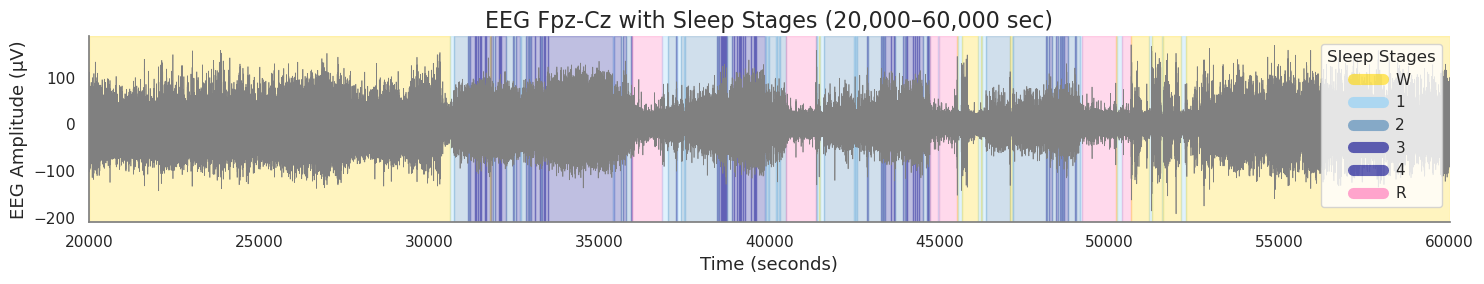

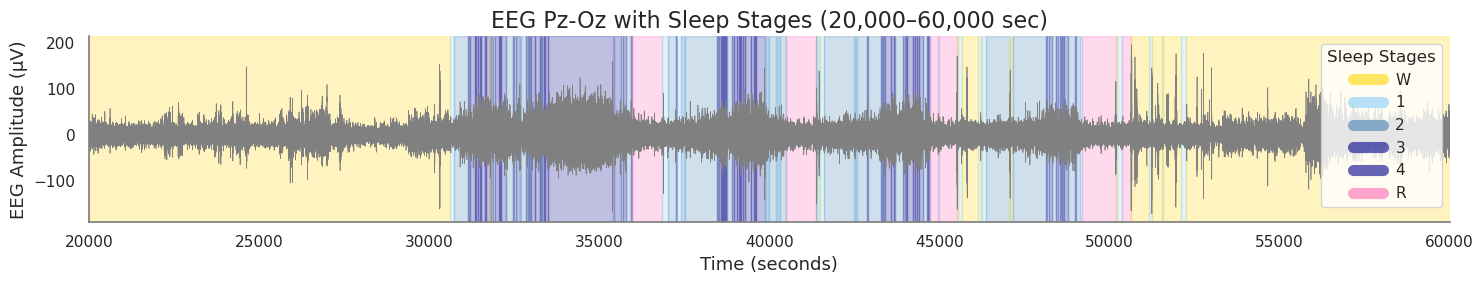

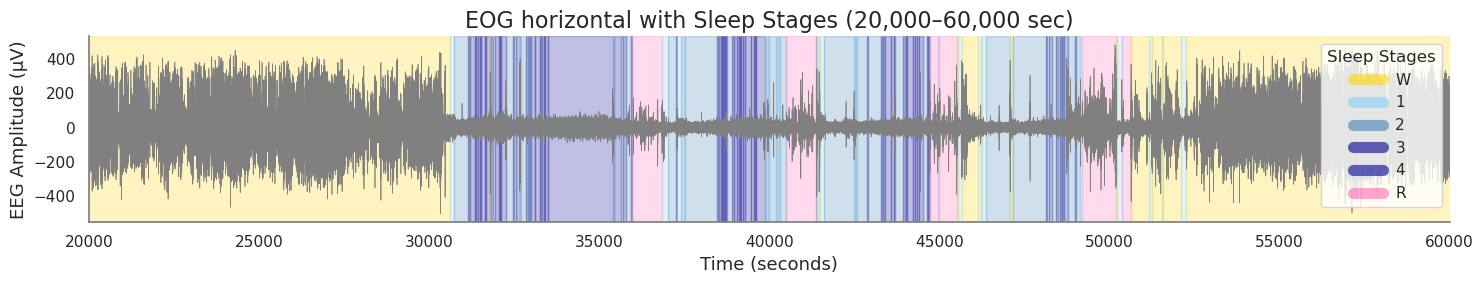

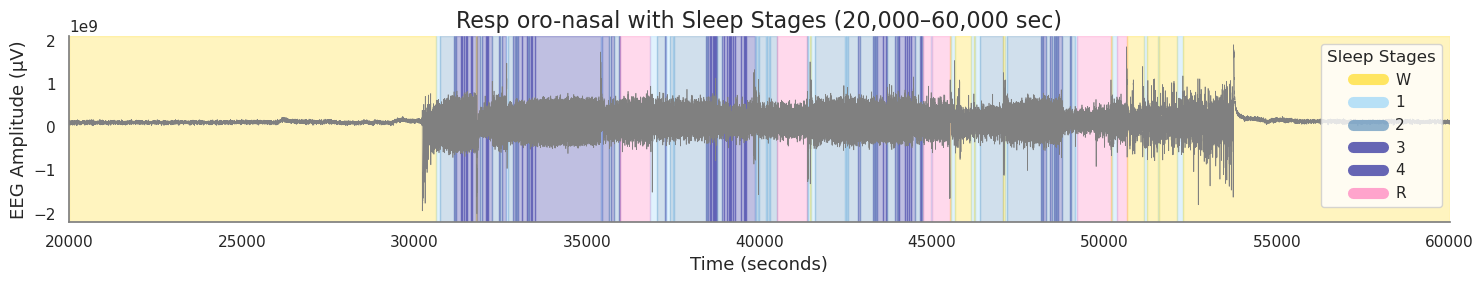

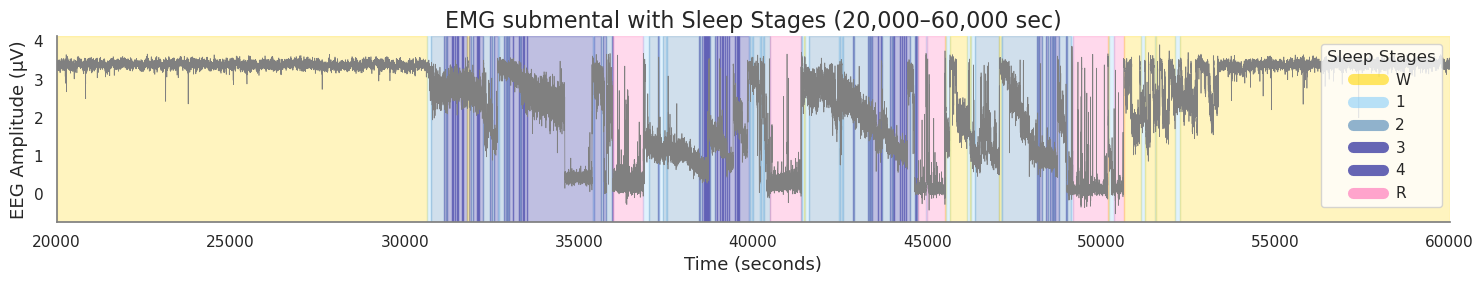

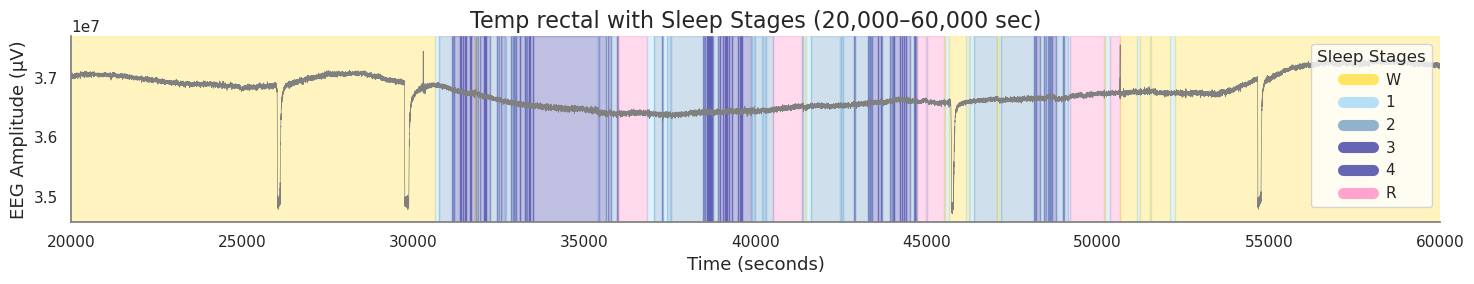

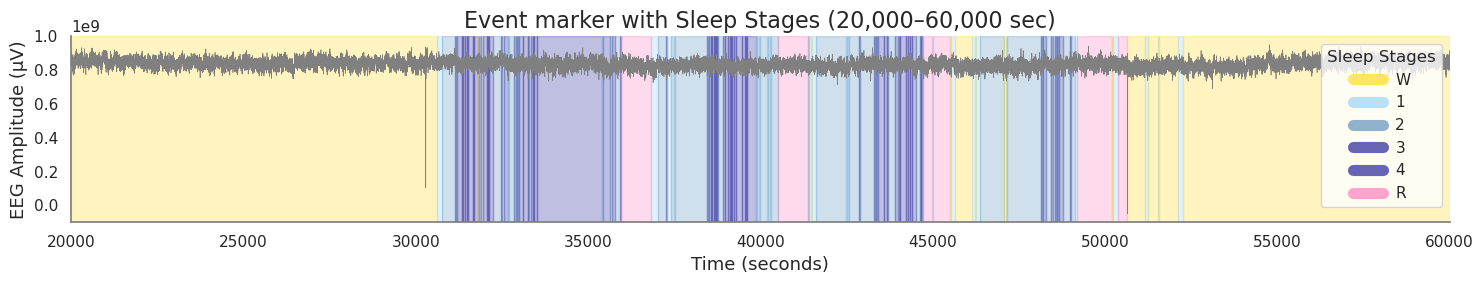

In [7]:
for rawpick in raw.ch_names:
    visualize_channel(rawpick)